In [264]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from aging.plotting import format_plots, figure, legend, save_factory, PlotConfig
from sklearn.decomposition import NMF
from tqdm.auto import tqdm
import colorcet as cc
from pathlib import Path

In [265]:
c = PlotConfig()
format_plots()

In [266]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [267]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [268]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid','mouse']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid','mouse']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]

In [269]:
new_grouping = data_all.groupby(['age','uuid']).mean()

In [270]:
## get components
group = new_grouping.groupby(['age']).mean()
ages = group.index.get_level_values('age').unique()
age_map = {i: ages[i] for i in range(27)}
n_components = 4
nmf = NMF(n_components=n_components, max_iter=750, random_state=0)
nmf.fit(group.T)
components=nmf.components_.T
# get syllable scores
out = nmf.transform(group.T)

In [271]:
from scipy.ndimage import gaussian_filter
sigma=1
smoothed_array = np.zeros_like(components)
for i in range(components.shape[1]):
    smoothed_array[:, i] = gaussian_filter(components[:, i], sigma=sigma)

In [272]:
to_plt = pd.DataFrame(smoothed_array)
to_plt = to_plt.reset_index().melt(id_vars=['index'])
to_plt['age'] = to_plt['index'].map(age_map)

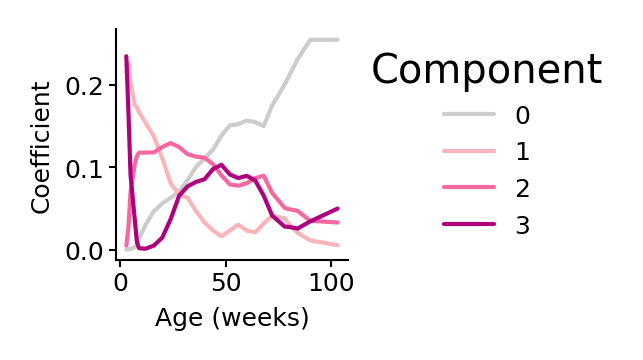

In [273]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=to_plt,
    estimator='mean',
    x="age",
    y="value",
    hue="variable",
    errorbar="sd",
    #palette=['#cccccc','#b2e2e2','#66c2a4','#238b45'],
    palette=['#cccccc','#fbb4b9','#f768a1','#ae017e'],
    err_kws=dict(lw=0),
)
sns.despine()
ax.set(ylim=(None, None), xlabel="Age (weeks)", ylabel="Coefficient")
legend(ax, title="Component")
sns.despine()
fig.savefig(c.dana_save_path / "fig2"/ 'nmf_components.pdf')

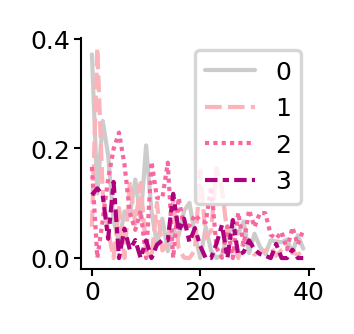

In [274]:
fig = figure(1, 1)
sns.lineplot(out, palette=['#cccccc','#fbb4b9','#f768a1','#ae017e'], linestyle='-')
sns.despine()
fig.savefig(c.dana_save_path / "fig2"/ 'nmf_score.pdf')

In [ ]:
to_plt = pd.DataFrame(smoothed_array)
to_plt = to_plt.reset_index().melt(id_vars=['index'])
to_plt['age'] = to_plt['index'].map(age_map)

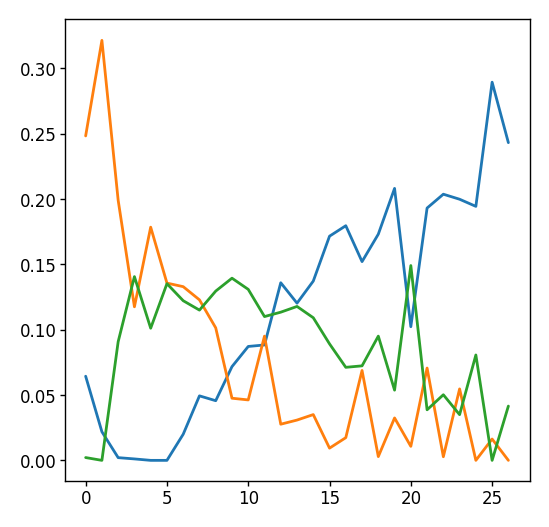

In [211]:
from scipy.ndimage import gaussian_filter
to_plt = pd.DataFrame(components)
plt.plot(to_plt)

In [212]:
## resample to get some error bars
n=8
n_shuffs = 1000
n_components = 3
#np.random.seed(0)
components = []
scores = []

for i in tqdm(range(n_shuffs)):
    temp_df = new_grouping.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)
    temp_df=temp_df.groupby('age').mean()
    nmf = NMF(n_components=n_components, max_iter=750, random_state=0)
    nmf.fit(temp_df.T)
    components.append(nmf.components_.T)
    
    out = nmf.transform(group.T)
    scores.append(out)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 750 reached. Increase it to improve convergence.
  warnings.warn(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 750 reached. Increase it to improve convergence.
  warnings.warn(


In [213]:
component_df = []
scores_df = []
for i, comp in enumerate(components):
    _df = pd.DataFrame(comp)
    _df['iteration'] = i
    component_df.append(_df)
    _df = pd.DataFrame(scores[i])
    _df['iteration'] = i
    scores_df.append(_df)
component_df = pd.concat(component_df)
scores_df = pd.concat(scores_df)

#scores_df.rename_axis('time')
#scores_df.rename_axis('syll')

In [214]:
to_plt = component_df.reset_index().melt(id_vars=['iteration', 'index'])
to_plt['age'] = to_plt['index'].map(age_map)

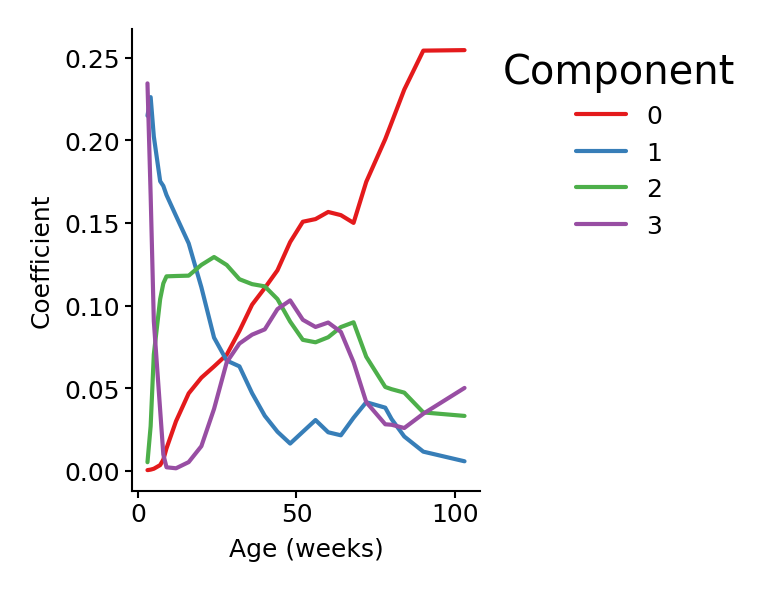

In [249]:
fig = figure(1.5, 2)
ax = sns.lineplot(
    data=to_plt,
    estimator='mean',
    x="age",
    y="value",
    hue="variable",
    errorbar="se",
    palette="Set1",
    #err_kws=dict(lw=0),
)
ax.set(ylim=(None, None), xlabel="Age (weeks)", ylabel="Coefficient")
legend(ax, title="Component")
sns.despine()

In [142]:
to_plt = component_df.reset_index().melt(id_vars=['iteration', 'index'])
to_plt['age'] = to_plt['index'].map(age_map) / 7

NameError: name 'saver' is not defined

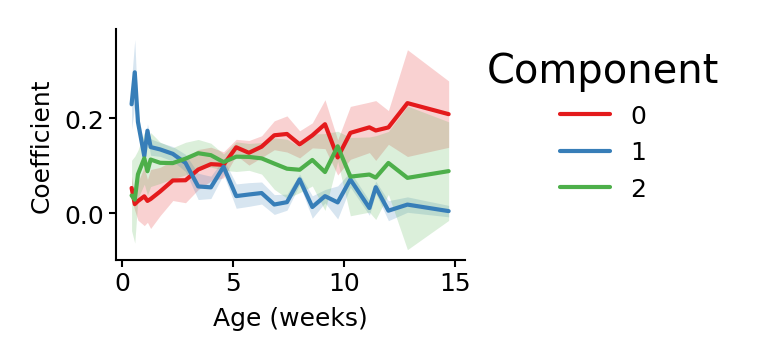

In [143]:
fig = figure(1.5, 1)
ax = sns.lineplot(
    data=to_plt,
    x="age",
    y="value",
    hue="variable",
    errorbar="sd",
    palette="Set1",
    err_kws=dict(lw=0),
)
ax.set(ylim=(None, None), xlabel="Age (weeks)", ylabel="Coefficient")
legend(ax, title="Component")
sns.despine()
saver(fig, "nmf-components");

In [15]:
to_plt = scores_df.reset_index().melt(id_vars=['iteration', 'index'])

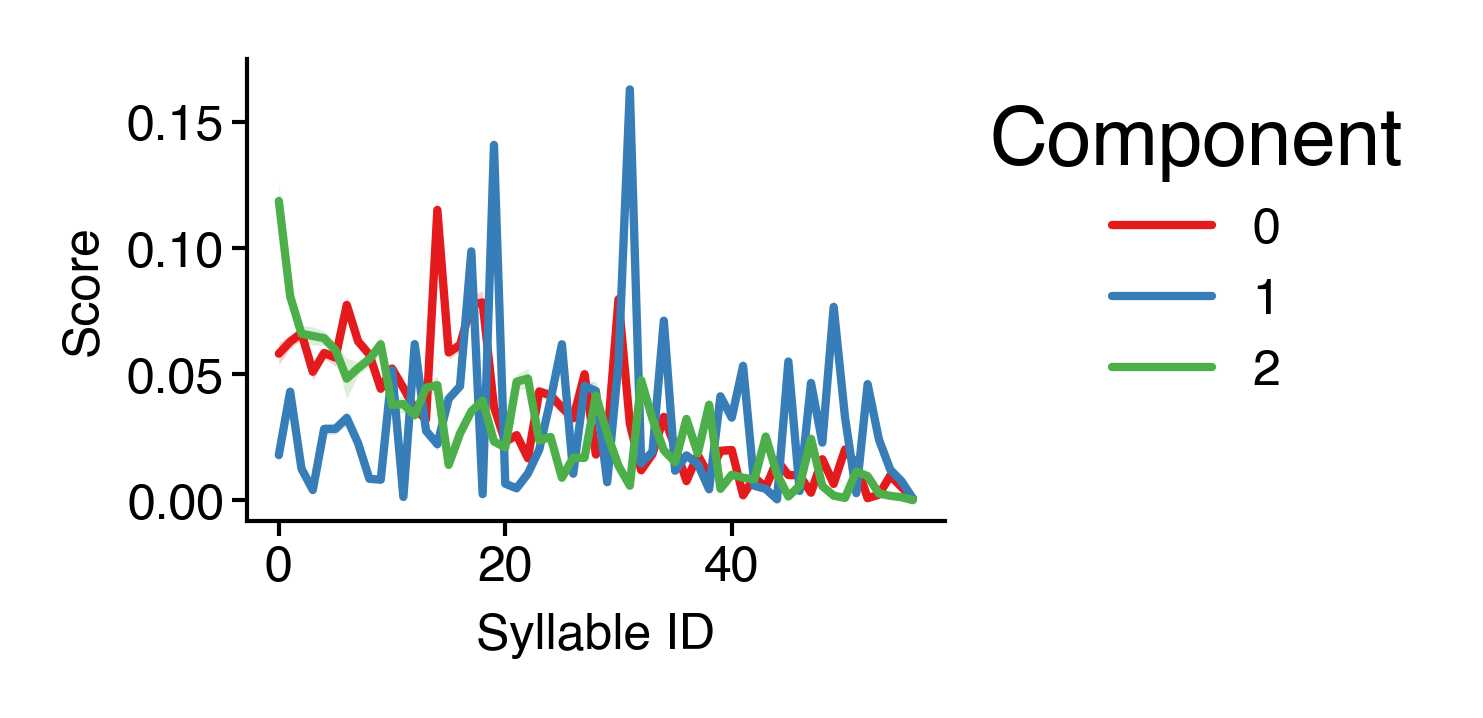

In [17]:
fig = figure(1.5, 1)
ax = sns.lineplot(
    data=to_plt,
    x="index",
    y="value",
    hue="variable",
    errorbar="sd",
    palette="Set1",
    err_kws=dict(lw=0),
)
ax.set(ylim=(None, None), xlabel="Syllable ID", ylabel="Score")
legend(ax, title="Component")
sns.despine()
saver(fig, "nmf-scores");

In [11]:
nmf.components_.shape

(3, 35)

In [15]:
out = nmf.transform(in_data)
out.shape

(741, 3)

In [27]:
arr.shape

(13, 35, 57)

In [28]:
reshaped = out.reshape(len(arr), 57, 3)

In [ ]:
scores_df = pd.DataFrame(out)
scores_df['syllable'] = np.tile(np.arange(57), 13)
scores_df = scores_df.melt(id_vars='syllable', var_name='component', value_name='score')

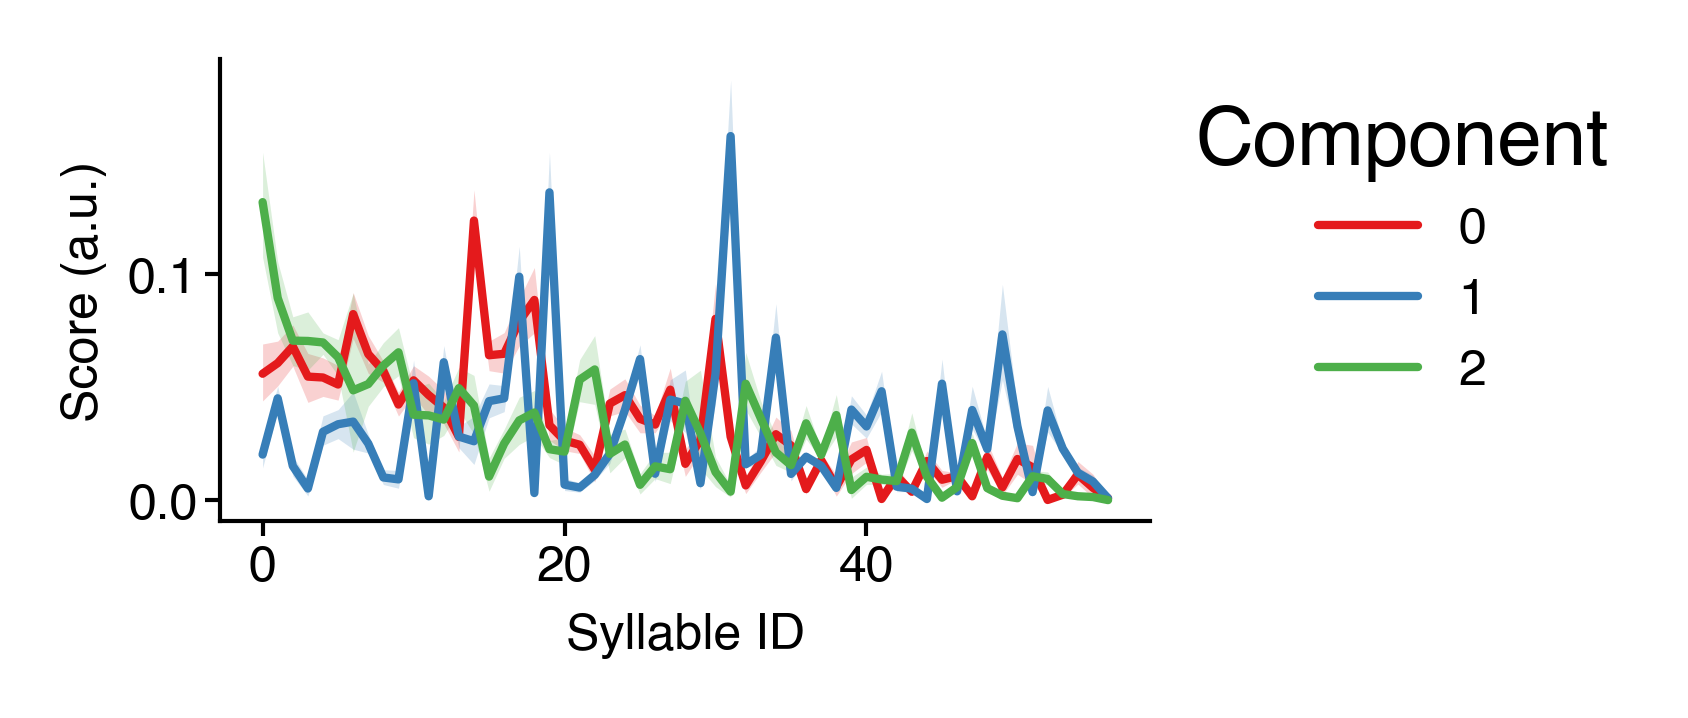

In [43]:
fig = figure(2, 1)
ax = sns.lineplot(
    data=scores_df,
    x="syllable",
    y="score",
    hue="component",
    errorbar=("ci", 95),
    palette="Set1",
    err_kws=dict(lw=0),
    lw=1
)
ax.set(xlabel="Syllable ID", ylabel="Score (a.u.)")
legend(ax, title="Component")
sns.despine()
saver(fig, "nmf-scores");